In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
plt.rc('font', size=18)

connection_args = {
    'host':'3.86.206.29',
    'user':'ubuntu',
    'dbname':'mid',
    'port':5432
}
connection = pg.connect(**connection_args)

def is_prime(n):
    for i in range(2,n):
        if n%i==0:
            return False
    return True

def largestPrimeFactor(n):
    for i in range(n,1,-1):
        if n%i==0:
            if is_prime(i):
                return i

## Join Economic Data to MIDB Level (Participants of MID)

In [2]:
midb = pd.read_stata('MID4/MIDB_4_3.dta')

In [3]:
midb.rename(columns={'dispnum3':'dispute_number_v3', 
                     'dispnum4':'dispute_number_v4',
                     'stabb':'state_abbriviated',
                     'ccode':'country_code',
                     'stday':'start_day', 
                     'stmon':'start_month', 
                     'styear':'start_year', 
                     'endday':'end_day',
                     'endmon':'end_month',
                     'endyear':'end_year',
                     'sidea':'is_side_a',
                     'revstate':'is_revisionist_state',
                     'revtype1':'revision_type_1',
                     'revtype2':'revision_type_2',
                     'fatality':'fatality_bucket',
                     'fatalpre':'fatalities_number',
                     'hiact':'highest_hostile_action[hostility_level]',
                     'hostlev':'hostility_level',
                     'orig':'dispute_originator',
                     'version':'dataset_version'
                    }, inplace=True)

In [4]:
midb.replace(to_replace=-9,value=np.nan, inplace=True)

In [5]:
midb.drop('dispute_number_v4', inplace=True, axis=1)
midb.drop('revision_type_2', inplace=True, axis=1)
midb['start_day'].replace(to_replace=np.nan,value=15, inplace=True)
midb['end_day'].replace(to_replace=np.nan,value=15, inplace=True)
midb.drop(['fatalities_number'], inplace=True, axis=1)
midb.drop(['dataset_version'], inplace=True, axis=1)
midb['mid_start'] = pd.to_datetime(dict(year=midb.start_year, month=midb.start_month, day=midb.start_day))
midb['mid_end'] = pd.to_datetime(dict(year=midb.end_year, month=midb.end_month, day=midb.end_day))
midb['fatality_bucket'].replace(to_replace=np.nan, value=999, inplace=True)

In [6]:
midb.head()

,dispute_number_v3,state_abbriviated,country_code,start_day,start_month,start_year,end_day,end_month,end_year,is_side_a,is_revisionist_state,revision_type_1,fatality_bucket,highest_hostile_action[hostility_level],hostility_level,dispute_originator,mid_start,mid_end
0,2,UKG,200,15.0,7,1902,24.0,1,1903,0,1,1,0.0,0,1,1,1902-07-15,1903-01-24
1,2,USA,2,15.0,7,1902,24.0,1,1903,1,1,1,0.0,7,3,1,1902-07-15,1903-01-24
2,3,YUG,345,2.0,5,1913,25.0,10,1913,0,0,0,0.0,0,1,1,1913-05-02,1913-10-25
3,3,AUH,300,2.0,5,1913,25.0,10,1913,1,1,2,0.0,8,3,1,1913-05-02,1913-10-25
4,4,ALB,339,15.0,5,1946,13.0,11,1946,1,0,0,0.0,16,4,1,1946-05-15,1946-11-13


In [7]:
#query = "SELECT count(*) FROM mil_exp;"
#pd_sql.read_sql(query, connection)

In [8]:
#query = "SELECT count(*) FROM midb;"
#pd_sql.read_sql(query, connection)

In [9]:
#query = "SELECT b.*, e.mil_exp FROM midb as b JOIN mil_exp as e on b.state_abbriviated = e.code \
#WHERE b.start_year == e.year;"
#pd_sql.read_sql(query, connection)

In [10]:
mil_exp = pd.read_csv('MID4/mil_exp_tall.csv')

In [11]:
mil_exp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 8 columns):
Unnamed: 0        15312 non-null int64
Unnamed: 0.1      15312 non-null int64
name              15312 non-null object
code              15312 non-null object
type              15312 non-null object
indicator_name    15312 non-null object
year              15312 non-null int64
mil_exp           9045 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 957.1+ KB


In [12]:
#midb.set_index(['state_abbriviated', 'start_year']).join(mil_exp.set_index(['code','year']))

In [13]:
newdf = pd.merge(midb, mil_exp, how='left', left_on=['state_abbriviated', 'start_year'], right_on=['code','year'])

In [14]:
gdp_hist = pd.read_csv('MID4/gdp_hist.csv')

In [15]:
newdf = pd.merge(newdf, gdp_hist, how='left', left_on=['state_abbriviated', 'start_year'], right_on=['code','year'])

In [16]:
#pd.merge(midb, gdp_hist, how='right', left_on=['state_abbriviated', 'start_year'], right_on=['code','year']).info()

In [17]:
population_hist = pd.read_csv('MID4/population_hist.csv')

In [18]:
newdf = pd.merge(newdf, population_hist, how='left', left_on=['state_abbriviated', 'start_year'], right_on=['code','year'])

In [19]:
#mil_exp.describe() 1960-2017

In [20]:
#midb.describe() 1980-2010

In [21]:
newdf = newdf[['dispute_number_v3', 'state_abbriviated', 'country_code', 'start_day',
       'start_month', 'start_year', 'end_day', 'end_month', 'end_year',
       'is_side_a', 'is_revisionist_state', 'revision_type_1',
       'fatality_bucket', 'highest_hostile_action[hostility_level]',
       'hostility_level', 'dispute_originator', 'mid_start', 'mid_end', 'mil_exp', 'gdp', 'population']]

Profiling all countries based on economy in 2017. Proxy, not historical variables.

In [22]:
e_2017 = pd.read_csv('MID4/country_profile_un_2017_rich.csv')

In [23]:
countries_map = pd.read_csv('MID4/wikipedia-iso-country-codes.csv')

In [24]:
countries_map.columns

Index(['English short name lower case', 'Alpha-2 code', 'Alpha-3 code',
       'Numeric code', 'ISO 3166-2'],
      dtype='object')

In [25]:
countries_map = countries_map[['English short name lower case','Alpha-3 code' ]]

In [26]:
e_2017 = pd.merge(e_2017, countries_map, how='left', left_on=['country'], right_on=['English short name lower case'])

In [27]:
e_2017.loc[24,'Alpha-3 code'] = 'BOL'
e_2017.loc[25,'Alpha-3 code'] = 'BES'
e_2017.loc[29,'Alpha-3 code'] = 'VGB'

e_2017.loc[34,'Alpha-3 code'] = 'CVP'
e_2017.loc[164,'Alpha-3 code'] = 'KOR'
e_2017.loc[55,'Alpha-3 code'] = 'PRK'
e_2017.loc[56,'Alpha-3 code'] = 'COD'
e_2017.loc[97,'Alpha-3 code'] = 'IRN'
e_2017.loc[116,'Alpha-3 code'] = 'LBY'

e_2017.loc[165,'Alpha-3 code'] = 'MDA'
e_2017.loc[167,'Alpha-3 code'] = 'RUS'
e_2017.loc[189,'Alpha-3 code'] = 'SSD'
e_2017.loc[192,'Alpha-3 code'] = 'PSE'
e_2017.loc[201,'Alpha-3 code'] = 'YUG'
e_2017.loc[210,'Alpha-3 code'] = 'TCA'
e_2017.loc[216,'Alpha-3 code'] = 'TZA'
e_2017.loc[217,'Alpha-3 code'] = 'USA'
e_2017.loc[218,'Alpha-3 code'] = 'VIR'
e_2017.loc[222,'Alpha-3 code'] = 'VEN'
e_2017.loc[223,'Alpha-3 code'] = 'VNM'
e_2017.loc[224,'Alpha-3 code'] = 'WLF'

In [28]:
e_2017.loc[224,'Alpha-3 code'] = 'WLF'

In [29]:
e_2017[e_2017['Alpha-3 code'].isnull()]

,Unnamed: 0,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),...,Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI),English short name lower case,Alpha-3 code
41,41,Channel Islands,NorthernEurope,180,165,870.1,98.4,-99,-99,-99.0,...,4.2,-99,-99,-99,-99,-99,-99,-99,NaN,NaN
43,43,"China, Hong Kong SAR",EasternAsia,1106,7365,7014.2,85.1,309236,2.4,42431.0,...,-99,46.2/6.4,-99,83,-99,-99,-99,-99,NaN,NaN
44,44,"China, Macao SAR",EasternAsia,30,623,20821.6,92.3,46178,-20.3,78586.4,...,-99,1.3/2.2,2,62,-99,-99,-99,-99,NaN,NaN
54,54,Czechia,EasternEurope,78868,10618,137.5,96.7,185156,4.5,17561.7,...,34.5,96.5/9.2,1221,164,100.0/100.0,99.1/99.2,-99,-99,NaN,NaN
91,91,Holy See,SouthernEurope,~0,1,1800.0,219.2,-99,-99,-99.0,...,-99,-99,-99,-99,-99,-99,-99,-99,NaN,NaN
132,132,Micronesia (Federated States of),Micronesia,702,106,150.8,105.1,315,3.7,3015.2,...,91.8,0.2/1.4,0,22,94.8/87.4,85.1/49.0,34.11,-99,NaN,NaN
169,169,Saint Helena,WesternAfrica,308,4,10.4,-99.0,-99,-99,-99.0,...,5.1,~0.0/3.1,0,41,-99,-99,-99,-99,NaN,NaN
183,183,Sint Maarten (Dutch part),Caribbean,34,40,1180.0,95.7,1094,0.5,28241.7,...,-99,0.7/19.5,-99,303,-99,-99,-99,-99,NaN,NaN


In [30]:
#e_2017[e_2017['Alpha-3 code']=='CHN']

In [31]:
newdf = newdf.merge(e_2017, how='left', left_on=['state_abbriviated'], right_on=['Alpha-3 code'])

In [32]:
newdf.rename(columns={'Surface area (km2)':'surface_area_km2',
                                   'Region':'region',
                                  'Population in thousands (2017)':'population_K',
                                  'Population density (per km2, 2017)':'population_density_per_km2',
                                  'Sex ratio (m per 100 f, 2017)':'sex_ratio_m_per_100_f',
                                  'GDP: Gross domestic product (million current US$)':'gdp_mln_usd',
                                  'GDP growth rate (annual %, const. 2005 prices)':'gdp_growth_rate_annual',
                                  'GDP per capita (current US$)':'gdp_per_capita_usd',
                                  'Economy: Agriculture (% of GVA)':'economy_agriculture_perc_GVA',
                                  'Economy: Industry (% of GVA)':'economy_industry_perc_GVA',
                                  'Economy: Services and other activity (% of GVA)':'economy_services_other_perc_GVA',
                                  'Employment: Agriculture (% of employed)':'employment_agriculture_perc',
                                  'Employment: Industry (% of employed)':'employment_industry_perc',
                                  'Employment: Services (% of employed)':'employment_services_perc',
                                  'Unemployment (% of labour force)':'unemployment_perc',
                                  'Labour force participation (female/male pop. %)':'labour_participation_gender_f_to_m_perc',
                                  'Agricultural production index (2004-2006=100)':'agricultural_production_index',
                                  'Food production index (2004-2006=100)':'food_production_index',
                                  'International trade: Exports (million US$)':'intl_trade_exports_mln_usd',
                                  'International trade: Imports (million US$)':'intl_trade_imports_mln_usd',
                                  'International trade: Balance (million US$)':'intl_trade_balance_mln_usd',
                                  'Balance of payments, current account (million US$)':'balance_payments_current_mln_usd',
                                  'Population growth rate (average annual %)':'population_growth_ann_perc',
                                  'Urban population (% of total population)':'urban_population',
                                  'Urban population growth rate (average annual %)':'urban_population_growth_rate_ann_perc',
                                  'Fertility rate, total (live births per woman)':'fertility_rate_live_births_per_f',
                                  'Life expectancy at birth (females/males, years)':'life_expectancy',
                                  'Population age distribution (0-14 / 60+ years, %)':'age_distribution_0-14_60+_perc',
                                  'International migrant stock (000/% of total pop.)':'intl_migration_population_perc',
                                  'Refugees and others of concern to UNHCR (in thousands)':'refugees_K',
                                   'Infant mortality rate (per 1000 live births':'infant_mortality_rate_per_1000_live',
                                   'Health: Total expenditure (% of GDP)':'health_expenditure_gdp_perc',
                                   'Health: Physicians (per 1000 pop.)':'health_physicians_per_1000',
                                   'Education: Government expenditure (% of GDP)':'edu_gov_expenditure_gdp_perc',
                                   'Education: Primary gross enrol. ratio (f/m per 100 pop.)':'edu_primary_gross_enroll_ratio_f/m_per_100',
                                   'Education: Secondary gross enrol. ratio (f/m per 100 pop.)':'edu_secondary_gross_enroll_ratio_f/m_per_100',
                                   'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)':'edu_tertiary_gross_enroll_ratio_f/m_per_100',
                                   'Seats held by women in national parliaments %':'female_seats_national_parliament_perc',
                                   'Mobile-cellular subscriptions (per 100 inhabitants)':'mobile_subscriptions_per_100',
                                   'Mobile-cellular subscriptions (per 100 inhabitants).1':'mobile_subscriptions_per_100_1',
                                   'Individuals using the Internet (per 100 inhabitants)':'internet_users_per_100',
                                   'Threatened species (number)':'threatened_species_n',
                                   'Forested area (% of land area)':'forest_area_perc', 
                                   'CO2 emission estimates (million tons/tons per capita)':'CO2_emiss_estimate_mln_ton_ton_per_capita',
                                   'Energy production, primary (Petajoules)':'energy_production_primary_petajoules',
                                   'Energy supply per capita (Gigajoules)':'energy_supply_per_capita_gigajoules',
                                   'Pop. using improved drinking water (urban/rural, %)':'population_improved_drinking_water_access_urban/rural_perc',
                                   'Pop. using improved sanitation facilities (urban/rural, %)':'population_improved_sanitation_facil_access_urban/rural_perc',
                                   'Net Official Development Assist. received (% of GNI)':'net_official_develop_assist_recieved_GNI_perc'}, inplace=True)

In [33]:
newdf.to_csv('MID4/MIDB_participants_economy.csv')

## Join Participants data as Features for dispute

Get participant 1 and participant 2 datasets

In [34]:
midb_e = pd.read_csv('MID4/MIDB_participants_economy.csv')

In [35]:
sidea = midb_e[midb_e['is_side_a'] == 1]
sidea = sidea.add_suffix('_a')

In [36]:
sideb = midb_e[midb_e['is_side_a'] == 0]
sideb = sideb.add_suffix('_b')

In [37]:
#sidea = sidea.add_suffix('_a')
#sideb = sideb.add_suffix('_b')

In [38]:
sidea.to_csv('MID4/midb_sidea.csv')
sideb.to_csv('MID4/midb_sideb.csv')

Cleaning MIDA (dispute level dataset). Converting dependent variable to binary.

In [39]:
mida = pd.read_stata('MID4/MIDA_4_3.dta')

In [40]:
mida.rename(columns={'dispnum3':'dispute_number_v3', 
                     'dispnum4':'dispute_number_v4', 
                     'stday':'start_day', 
                     'stmon':'start_month', 
                     'styear':'start_year', 
                     'endday':'end_day',
                     'endmon':'end_month',
                     'endyear':'end_year',
                     'fatality':'fatality_bucket',
                     'fatalpre':'fatalities_number',
                     'maxdur':'maximum_diration',
                     'mindur':'minimum_duration',
                     'hiact':'highest_hostile_action[hostility_level]',
                     'hostlev':'hostility_level',
                     'resip':'resiprocated_dispute',
                     'numa':'number_states_side_a',
                     'numb':'number_states_side_b',
                     'link1':'related_dispute_number_1',
                     'link2':'related_dispute_number_2',
                     'link3':'related_dispute_number_3',
                     'ongo2010':'ongoing_2010',
                     'version':'dataset_version'
                    }, inplace=True)

In [41]:
mida.replace(to_replace=-9,value=np.nan, inplace=True)
mida.drop('dispute_number_v4', inplace=True, axis=1)
mida['start_day'].replace(to_replace=np.nan,value=15, inplace=True)
mida['end_day'].replace(to_replace=np.nan,value=15, inplace=True)
mida.drop(['fatalities_number'], inplace=True, axis=1)
mida.drop(['dataset_version'], inplace=True, axis=1)
mida['mid_start'] = pd.to_datetime(dict(year=mida.start_year, 
                                        month=mida.start_month, 
                                        day=mida.start_day)).astype(int)/10**9
mida['mid_end'] = pd.to_datetime(dict(year=mida.end_year, 
                                      month=mida.end_month, 
                                      day=mida.end_day)).astype(int)/10**9
mida['fatality_bucket'].replace(to_replace=np.nan, value=999, inplace=True)
mida['settle'].replace(to_replace=np.nan, value=4, inplace=True)
mida['related_dispute_number_3'].replace(to_replace=np.nan, value=0, inplace=True)
mida['outcome'].replace(to_replace=np.nan, value=8, inplace=True)
mida = mida[(mida['number_states_side_a'] == 1) & (mida['number_states_side_b'] == 1)]
mida['related_dispute_number_1'][mida['related_dispute_number_1']=='147W'] = np.nan
mida['related_dispute_number_2'][mida['related_dispute_number_2']=='166W'] = np.nan
#mida['related_dispute_number_1'] = mida['related_dispute_number_1'].astype(int)
#mida['related_dispute_number_2'] = mida['related_dispute_number_2'].astype(int)

In [42]:
mida.dropna(inplace=True)

In [43]:
#dependent var into bin: use force in dispute
mida['hostility_level'].replace(to_replace=2,value=0, inplace=True) 
mida['hostility_level'].replace(to_replace=3,value=0, inplace=True) 
mida['hostility_level'].replace(to_replace=4,value=1, inplace=True) 
mida['hostility_level'].replace(to_replace=5,value=1, inplace=True) 

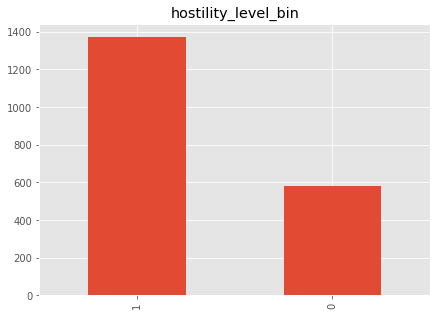

In [44]:
ax = mida['hostility_level'].value_counts().plot(kind='bar', figsize=(7,5), title='hostility_level_bin')

Megring participant level data to dispute level - set of features per side.

In [45]:
sidea.head()

,Unnamed: 0_a,dispute_number_v3_a,state_abbriviated_a,country_code_a,start_day_a,start_month_a,start_year_a,end_day_a,end_month_a,end_year_a,...,threatened_species_n_a,forest_area_perc_a,CO2_emiss_estimate_mln_ton_ton_per_capita_a,energy_production_primary_petajoules_a,energy_supply_per_capita_gigajoules_a,population_improved_drinking_water_access_urban/rural_perc_a,population_improved_sanitation_facil_access_urban/rural_perc_a,net_official_develop_assist_recieved_GNI_perc_a,English short name lower case_a,Alpha-3 code_a
1,1,2,USA,2,15.0,7,1902,24.0,1,1903,...,33.9,5254.3/16.2,83887.0,289.0,99.4/98.2,100.0/100.0,-99,-99.0,NaN,USA
3,3,3,AUH,300,2.0,5,1913,25.0,10,1913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,ALB,339,15.0,5,1946,13.0,11,1946,...,28.2,5.7/2.0,84.0,36.0,94.9/95.2,95.5/90.2,2.96,-99.0,Albania,ALB
6,6,7,UKG,200,13.0,10,1951,26.0,1,1952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,8,UKG,200,15.0,7,1856,14.0,3,1857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
sideb.columns

Index(['Unnamed: 0_b', 'dispute_number_v3_b', 'state_abbriviated_b',
       'country_code_b', 'start_day_b', 'start_month_b', 'start_year_b',
       'end_day_b', 'end_month_b', 'end_year_b', 'is_side_a_b',
       'is_revisionist_state_b', 'revision_type_1_b', 'fatality_bucket_b',
       'highest_hostile_action[hostility_level]_b', 'hostility_level_b',
       'dispute_originator_b', 'mid_start_b', 'mid_end_b', 'mil_exp_b',
       'gdp_b', 'population_b', 'Unnamed: 0.1_b', 'country_b', 'region_b',
       'surface_area_km2_b', 'population_K_b', 'population_density_per_km2_b',
       'sex_ratio_m_per_100_f_b', 'gdp_mln_usd_b', 'gdp_growth_rate_annual_b',
       'gdp_per_capita_usd_b', 'economy_agriculture_perc_GVA_b',
       'economy_industry_perc_GVA_b', 'economy_services_other_perc_GVA_b',
       'employment_agriculture_perc_b', 'employment_industry_perc_b',
       'employment_services_perc_b', 'unemployment_perc_b',
       'labour_participation_gender_f_to_m_perc_b',
       'agricultura

In [47]:
sidea = sidea[['dispute_number_v3_a', 'start_year_a', 'end_year_a', 
       'is_revisionist_state_a', 'revision_type_1_a', 'dispute_originator_a', 
               'mid_start_a', 'mid_end_a','mil_exp_a', 'gdp_a', 'population_a', 'country_a', 'region_a',
       'surface_area_km2_a', 'population_K_a', 'population_density_per_km2_a',
       'sex_ratio_m_per_100_f_a', 'gdp_mln_usd_a', 'gdp_growth_rate_annual_a',
       'gdp_per_capita_usd_a', 'economy_agriculture_perc_GVA_a',
       'economy_industry_perc_GVA_a', 'economy_services_other_perc_GVA_a',
       'employment_agriculture_perc_a', 'employment_industry_perc_a',
       'employment_services_perc_a', 'unemployment_perc_a',
       'labour_participation_gender_f_to_m_perc_a',
       'agricultural_production_index_a', 'food_production_index_a',
       'intl_trade_exports_mln_usd_a', 'intl_trade_imports_mln_usd_a',
       'intl_trade_balance_mln_usd_a', 'balance_payments_current_mln_usd_a',
       'population_growth_ann_perc_a', 'urban_population_a',
       'urban_population_growth_rate_ann_perc_a',
       'fertility_rate_live_births_per_f_a', 'life_expectancy_a',
       'age_distribution_0-14_60+_perc_a', 'intl_migration_population_perc_a',
       'refugees_K_a', 'infant_mortality_rate_per_1000_live_a',
       'health_expenditure_gdp_perc_a', 'health_physicians_per_1000_a',
       'edu_gov_expenditure_gdp_perc_a',
       'edu_primary_gross_enroll_ratio_f/m_per_100_a',
       'edu_secondary_gross_enroll_ratio_f/m_per_100_a',
       'edu_tertiary_gross_enroll_ratio_f/m_per_100_a',
       'female_seats_national_parliament_perc_a',
       'mobile_subscriptions_per_100_a', 'mobile_subscriptions_per_100_1_a',
       'internet_users_per_100_a', 'threatened_species_n_a',
       'forest_area_perc_a', 'CO2_emiss_estimate_mln_ton_ton_per_capita_a',
       'energy_production_primary_petajoules_a',
       'energy_supply_per_capita_gigajoules_a',
       'population_improved_drinking_water_access_urban/rural_perc_a',
       'population_improved_sanitation_facil_access_urban/rural_perc_a',
       'net_official_develop_assist_recieved_GNI_perc_a',
       'English short name lower case_a', 'Alpha-3 code_a']]
sidea.rename(columns={'dispute_number_v3_a':'dispute_number_v3'}, inplace=True)

In [48]:
mida_ae = mida.join(sidea.set_index('dispute_number_v3'))

In [49]:
sideb = sideb[['dispute_number_v3_b', 'start_year_b', 'end_year_b', 
       'is_revisionist_state_b', 'revision_type_1_b', 'dispute_originator_b', 'mid_start_b', 'mid_end_b',
               'mil_exp_b','gdp_b', 'population_b', 'country_b', 'region_b',
       'surface_area_km2_b', 'population_K_b', 'population_density_per_km2_b',
       'sex_ratio_m_per_100_f_b', 'gdp_mln_usd_b', 'gdp_growth_rate_annual_b',
       'gdp_per_capita_usd_b', 'economy_agriculture_perc_GVA_b',
       'economy_industry_perc_GVA_b', 'economy_services_other_perc_GVA_b',
       'employment_agriculture_perc_b', 'employment_industry_perc_b',
       'employment_services_perc_b', 'unemployment_perc_b',
       'labour_participation_gender_f_to_m_perc_b',
       'agricultural_production_index_b', 'food_production_index_b',
       'intl_trade_exports_mln_usd_b', 'intl_trade_imports_mln_usd_b',
       'intl_trade_balance_mln_usd_b', 'balance_payments_current_mln_usd_b',
       'population_growth_ann_perc_b', 'urban_population_b',
       'urban_population_growth_rate_ann_perc_b',
       'fertility_rate_live_births_per_f_b', 'life_expectancy_b',
       'age_distribution_0-14_60+_perc_b', 'intl_migration_population_perc_b',
       'refugees_K_b', 'infant_mortality_rate_per_1000_live_b',
       'health_expenditure_gdp_perc_b', 'health_physicians_per_1000_b',
       'edu_gov_expenditure_gdp_perc_b',
       'edu_primary_gross_enroll_ratio_f/m_per_100_b',
       'edu_secondary_gross_enroll_ratio_f/m_per_100_b',
       'edu_tertiary_gross_enroll_ratio_f/m_per_100_b',
       'female_seats_national_parliament_perc_b',
       'mobile_subscriptions_per_100_b', 'mobile_subscriptions_per_100_1_b',
       'internet_users_per_100_b', 'threatened_species_n_b',
       'forest_area_perc_b', 'CO2_emiss_estimate_mln_ton_ton_per_capita_b',
       'energy_production_primary_petajoules_b',
       'energy_supply_per_capita_gigajoules_b',
       'population_improved_drinking_water_access_urban/rural_perc_b',
       'population_improved_sanitation_facil_access_urban/rural_perc_b',
       'net_official_develop_assist_recieved_GNI_perc_b',
       'English short name lower case_b', 'Alpha-3 code_b']]
sideb.rename(columns={'dispute_number_v3_b':'dispute_number_v3'}, inplace=True)

In [50]:
mida_ae_be = mida_ae.join(sideb.set_index('dispute_number_v3'))

In [51]:
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#mida_ae_be.dropna().shape
mida_ae_be.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2314
Data columns (total 147 columns):
dispute_number_v3                                                 2434 non-null int16
start_day                                                         2434 non-null float64
start_month                                                       2434 non-null int8
start_year                                                        2434 non-null int16
end_day                                                           2434 non-null float64
end_month                                                         2434 non-null int8
end_year                                                          2434 non-null int16
outcome                                                           2434 non-null float64
settle                                                            2434 non-null float64
fatality_bucket                                                   2434 non-null float64
maximum_diration        

In [52]:
mida_ae_be.drop(['start_year_a', 'start_year_b', 'end_year_a', 'end_year_b'], axis=1, inplace=True)

Scaling and Hot Encoding

In [53]:
#mida_ae_be.drop([], axis=1, inplace=False)

#'start_day', 'start_month', 'end_day', 'end_month', 'highest_hostile_action[hostility_level]', 'English short name lower case_b'
#'forest_area_perc_b', 'energy_supply_per_capita_gigajoules_b', 'population_improved_drinking_water_access_urban/rural_perc_b', 
#'forest_area_perc_a', 'energy_supply_per_capita_gigajoules_a', 'population_improved_drinking_water_access_urban/rural_perc_a'
#'mil_exp_a', 'gdp_a', 'population_a', 'mil_exp_b', 'gdp_b', 'population_b'
#'English short name lower case_a', 'Alpha-3 code_a', 'Alpha-3 code_b'
#'edu_primary_gross_enroll_ratio_f/m_per_100_a', 'edu_secondary_gross_enroll_ratio_f/m_per_100_a', 'edu_tertiary_gross_enroll_ratio_f/m_per_100_a'
#'edu_primary_gross_enroll_ratio_f/m_per_100_b', 'edu_secondary_gross_enroll_ratio_f/m_per_100_b', 'edu_tertiary_gross_enroll_ratio_f/m_per_100_b'
#'mid_start_a', 'mid_start_b', 'country_a', 'country_b', 'region_a', 'region_b', 'mid_end_a', 'mid_end_b'
#'start_year_a', 'start_year_b', 'end_year_a', 'end_year_b'

#'related_dispute_number_1', 'related_dispute_number_2', 'related_dispute_number_3'

## Toy Classifications

In [54]:
mida_ae_be.dropna().shape

(63, 143)

In [55]:
toy = mida_ae_be[['hostility_level', 'start_year', 'end_year', 'outcome', 'settle', 'fatality_bucket', 'maximum_diration', 'minimum_duration',
           'recip','mid_start', 'mid_end', 'is_revisionist_state_a', 'is_revisionist_state_b', 'revision_type_1_a',
           'dispute_originator_a', 'revision_type_1_b', 'dispute_originator_b']]

In [56]:
toy = toy.dropna()

In [57]:
dum_outcome = pd.get_dummies(toy['outcome'])

In [58]:
dum_settle = pd.get_dummies(toy['settle'])

In [59]:
dum_revision_type_1_a = pd.get_dummies(toy['revision_type_1_a'])

In [60]:
dum_revision_type_1_b = pd.get_dummies(toy['revision_type_1_b'])

In [61]:
toy = toy.drop(['outcome', 'settle', 'revision_type_1_a', 'revision_type_1_b'], axis=1)

In [62]:
toy = toy.join(dum_outcome, rsuffix='o')
#toy = toy.join(dum_settle, rsuffix='s')
#toy = toy.join(dum_revision_type_1_a, rsuffix='r1')
#toy = toy.join(dum_revision_type_1_b, rsuffix='r2' )

In [63]:
toy = toy.join(dum_settle, rsuffix='s')

In [64]:
toy = toy.join(dum_revision_type_1_a, rsuffix='r1')

In [65]:
toy = toy.join(dum_revision_type_1_b, rsuffix='r2' )

In [66]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
import warnings


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [68]:
toy.columns

Index([       'hostility_level',             'start_year',
                     'end_year',        'fatality_bucket',
             'maximum_diration',       'minimum_duration',
                        'recip',              'mid_start',
                      'mid_end', 'is_revisionist_state_a',
       'is_revisionist_state_b',   'dispute_originator_a',
         'dispute_originator_b',                    '1.0',
                          '2.0',                    '3.0',
                          '4.0',                      5.0,
                            6.0,                      7.0,
                            8.0,                      9.0,
                         '1.0s',                   '2.0s',
                         '3.0s',                   '4.0s',
                          '0.0',                    '1.0',
                          '2.0',                    '3.0',
                          '4.0',                  '0.0r2',
                        '1.0r2',                  '2.0r2

In [ ]:
train = toy[toy['start_year'] < 1990]
test = toy[toy['start_year'] > 1990]

In [71]:
toy.head()

,hostility_level,start_year,end_year,fatality_bucket,maximum_diration,minimum_duration,recip,mid_start,mid_end,is_revisionist_state_a,...,0.0,1.0,2.0,3.0,4.0,0.0r2,1.0r2,2.0r2,3.0r2,4.0r2
2,1,1946,1946,2.0,183,183,1,-7.458048e+08,-7.300800e+08,1.0,...,0,1,0,0,0,0,1,0,0,0
3,1,1951,1952,2.0,106,106,1,-5.749920e+08,-5.659200e+08,1.0,...,0,0,1,0,0,1,0,0,0,0
4,1,1856,1857,6.0,257,227,1,-3.580589e+09,-3.559680e+09,0.0,...,1,0,0,0,0,1,0,0,0,0
9,0,1895,1895,0.0,78,78,0,-2.341958e+09,-2.335306e+09,1.0,...,0,1,0,0,0,1,0,0,0,0
13,0,1945,1946,0.0,173,173,0,-7.611840e+08,-7.463232e+08,1.0,...,0,0,1,0,0,1,0,0,0,0
